In [ ]:
!pip install pgmpy

In [30]:
import numpy as np
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import BeliefPropagation
import matplotlib.pyplot as plt
import networkx as nx
import re

### Ex. 2.
Considerăm o regiune în care observăm vremea la mai multe stații meteo, $S_1, S_2, \dots, S_n$.
Fiecare stație raportează una dintre cele trei stări: „Soare”, „Ploaie” sau „Nori”. Vrem să prezicem starea vremii la fiecare stație meteo, luând în considerare dependențele dintre stațiile adiacente. Considerăm că vremea la o stație depinde direct de vremea la stațiile vecine.

Vom folosi o rețea Markoviană pentru a modela vremea la mai multe locații și vom inferea asupra vremii la o stație necunoscută, pe baza datelor de la vecini.

#### Date de intrare (introduse de către utilizator):
- numărul de stații meteo, $n$;
- muchiile corespunzătoare rețelei Markoviene, adică vecinii fiecărei stații. Pentru simplitate, vom presupune că rețeaua este aciclică, adică nu există clici de dimensiune 3;
- probabilitățile inițiale pentru fiecare stație (exemplu: $P(S) = 0.5, P(P) = 0.3, P(N) = 0.2$).

Folosind **pgmpy**, definiți o rețea Markoviană pentru problema de mai sus, unde potențialul pentru fiecare pereche de stații vecine (adiacente) este dat de matricea:


\begin{bmatrix}
0.7 & 0.2 & 0.1 \\
0.2 & 0.6 & 0.2 \\
0.1 & 0.3 & 0.6
\end{bmatrix}


Folosind metoda **Maximum A Posteriori (MAP)** pentru a prezice starea vremii la fiecare stație meteo (în **pgmpy**, puteți apela funcțiile **BeliefPropagation** și **map_query**).


In [31]:
def date_intrare():

    nr_statii = int(input("Introdu numarul de statii meteo: "))
    statii = [f'S{i+1}' for i in range(nr_statii)]

    while True:
        try:
            muchii_input = input("Introdu muchiile sub forma perechilor separate prin virgula (ex.: S1-S2,S2-S3): ")
            pattern = r'^S\d+-S\d+$'
            muchii = muchii_input.split(',')

            if all(re.match(pattern, muchie) for muchie in muchii):
                muchii = [tuple(muchie.split('-')) for muchie in muchii]
                break
            else:
                raise ValueError
        except ValueError:
            print("Eroare! Foloseste formatul corect (ex.: S1-S2,S2-S3).")

    prob_initiale = {}
    for statie in statii:
        while True:
            try:
                print(f"Introdu probabilitatile pentru statia {statie}:")
                soare = float(input("Prob. Soare: "))
                ploaie = float(input("Prob. Ploaie: "))
                nori = float(input("Prob. Nori: "))

                if soare + ploaie + nori == 1.0:
                    prob_initiale[statie] = [soare, ploaie, nori]
                    break
                else:
                    print("Eroare! Suma probabilitatilor trebuie sa fie egala cu 1!")
            except ValueError:
                print("Eroare! Introdu valori numerice pentru probabilitati.")

    return statii, muchii, prob_initiale

Introdu probabilitatile pentru statia S1:
Introdu probabilitatile pentru statia S2:
Introdu probabilitatile pentru statia S3:
Introdu probabilitatile pentru statia S4:
Introdu probabilitatile pentru statia S5:

Vremea prezisa la fiecare statie:
S1: Soare
S2: Soare
S3: Soare
S4: Soare
S5: Soare




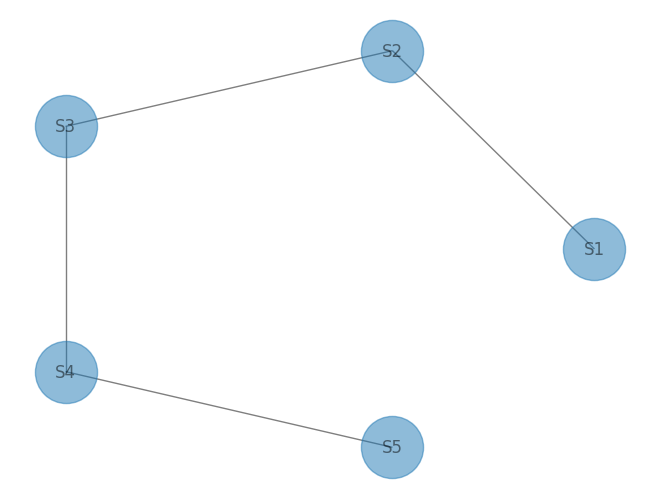

In [32]:
# 1. Preluam datele de intrare
statii, muchii, prob_initiale = date_intrare()

# 2. Cream Reteaua Markov
model = MarkovNetwork()
model.add_nodes_from(statii)
model.add_edges_from(muchii)

# Vizualizam Reteaua
pos = nx.circular_layout(model)
nx.draw(model, with_labels=True, pos=pos, alpha=0.5, node_size=2000)
00
# 3. Adaugam factorii de probabilitate initiali pentru fiecare statie
for statie, prob in prob_initiale.items():
    factor = DiscreteFactor(
        variables=[statie],
        cardinality=[3],
        values=prob
    )
    model.add_factors(factor)

# 4. Definim potentialul între statiile adiacente
potential_matrix = [[0.7, 0.2, 0.1],
                    [0.2, 0.6, 0.2],
                    [0.1, 0.3, 0.6]]

# 5. Adaugam factorii pentru fiecare pereche de statii adiacente
for muchie in muchii:
    factor = DiscreteFactor(
        variables=muchie,
        cardinality=[3, 3],
        values=potential_matrix
    )
    model.add_factors(factor)

# 6. Aplicam inferenta
bp_infer = BeliefPropagation(model)
marginals = bp_infer.map_query(variables=statii)

# 7. Convertim rezultatele
stari_vreme = {0: 'Soare', 1: 'Ploaie', 2: 'Nori'}
vreme_prezisa = {statie: stari_vreme[stare] for statie, stare in marginals.items()}

# 8. Afisam rezultatele
print('\nVremea prezisa la fiecare statie:')
for statie, vreme in vreme_prezisa.items():
    print(f'{statie}: {vreme}')
print('\n')

## Ex. 3
O problemă clasică care poate fi rezolvată folosind Markov Random Fields (MRF) este cea a denoisng-ului imaginii, unde obiectivul este de a curăța o imagine cu zgomot (noise) prin estimarea valorii fiecărui pixel, bazându-ne pe vecinii săi.

a) Alegeți mai întâi o imagine de dimensiune foarte mică (de ordinul 5 × 5), pe care să o utilizați drept **imagine originală**. Imaginea poate fi creată în mod determinist sau aleatoriu.

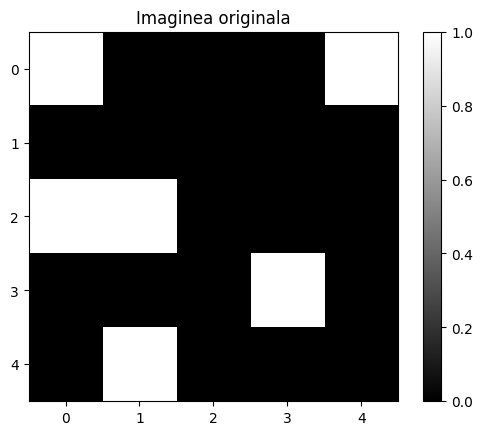

[[1 0 0 0 1]
 [0 0 0 0 0]
 [1 1 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]]


In [33]:
img_size = (5, 5)

original_image = np.random.choice([0, 1], size=img_size)

plt.imshow(original_image, cmap='gray')
plt.title("Imaginea originala")
plt.colorbar()
plt.show()
print(original_image)

b) Alegeți la întâmplare un număr de pixeli (în jur de 10%) pentru a fi modificați și creați astfel o modificare zgomotoasă a imaginii originale.

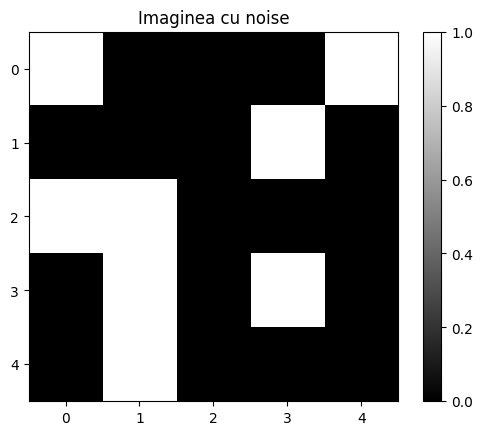

[[1 0 0 0 1]
 [0 0 0 1 0]
 [1 1 0 0 0]
 [0 1 0 1 0]
 [0 1 0 0 0]]


In [34]:
procent_noise = 0.1
nr_pixels_change = int(procent_noise * img_size[0] * img_size[1])

noisy_image = original_image.copy()

noise_indices = np.random.choice(img_size[0] * img_size[1], nr_pixels_change, replace=False)

for idx in noise_indices:
    row, col = divmod(idx, img_size[1])
    noisy_image[row, col] = 1 - noisy_image[row, col]

plt.imshow(noisy_image, cmap='gray')
plt.title("Imaginea cu noise")
plt.colorbar()
plt.show()

print(noisy_image)

Considerăm un grid 2D, în care fiecare nod (pixel) este conectat la cei patru vecini direcți (N, S, E, W). Energia totală $E(x)$ a unui grid poate fi descrisă de două componente:

- O componentă care penalizează discrepanțele între variabilele observate și cele latente.
- O componentă care penalizează discrepanțele între pixelii vecini, favorizând o imagine mai uniformă.

Funcția de energie poate fi scrisă astfel:

$$
E(x) = \sum_{i} \lambda (x_i - y_i)^2 + \sum_{(i,j)} (x_i - x_j)^2
$$

unde

- $x_i$ este pixelul curat de estimat;
- $y_i$ este pixelul observat;
- $\lambda$ este un factor de regularizare care controlează influența zgomotului, ales de utilizator;
- $(i, j)$ reprezintă perechi de pixeli vecini.

c) Folosind `pgmpy`, definiți o rețea Markoviană care să descrie contextul de mai sus.

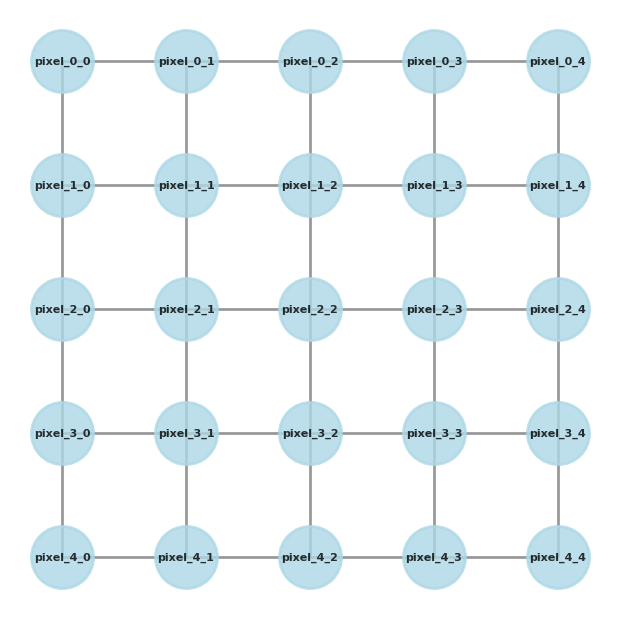

In [41]:
# Cream Reteaua Markov
model = MarkovNetwork()

# Adaugam noduri pentru fiecare pixel
for i in range(img_size[0]):
    for j in range(img_size[1]):
        model.add_node(f'pixel_{i}_{j}')

# Adaugam conexiuni intre pixeli vecini (N, S, E, W)
for i in range(img_size[0]):
    for j in range(img_size[1]):
        if i > 0: # Nord
            model.add_edge(f'pixel_{i}_{j}', f'pixel_{i-1}_{j}')
        if i < img_size[0] - 1: # Sud
            model.add_edge(f'pixel_{i}_{j}', f'pixel_{i+1}_{j}')
        if j > 0: # Vest
            model.add_edge(f'pixel_{i}_{j}', f'pixel_{i}_{j-1}')
        if j < img_size[1] - 1: # Est
            model.add_edge(f'pixel_{i}_{j}', f'pixel_{i}_{j+1}')

# Vizualizam Reteaua
G = nx.Graph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())

pos_nx = {f'pixel_{i}_{j}': (j, -i) for i in range(img_size[0]) for j in range(img_size[1])}
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos_nx, with_labels=True, node_size=2000, node_color='lightblue', font_size=8, font_weight='bold',
        edge_color='gray', width=2, alpha=0.8, linewidths=2)

d) Folosiți metoda **Maximum A Posteriori (MAP)** pentru a estima **imaginea originală** pornind de la cea modificată (la fel ca la Ex. 2, puteți apela funcțiile `BeliefPropagation` și `map_query`).

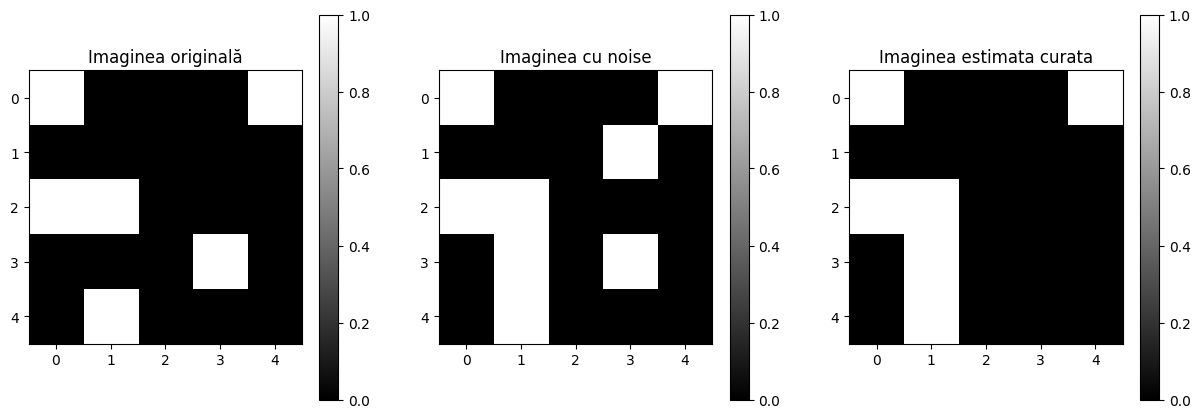

In [42]:
lambda_val = 3.0

for i in range(img_size[0]):
    for j in range(img_size[1]):
        # Factor pentru penalizarea discrepanței între pixelul observat și cel estimat
        factor = DiscreteFactor(
            variables=[f'pixel_{i}_{j}'],
            cardinality=[2],
            values = [np.exp(-lambda_val * (val - noisy_image[i, j])**2) for val in [0, 1]]
        )
        model.add_factors(factor)

# Penalizarea discrepantelor intre vecini
for (pixel1, pixel2) in model.edges():
    factor = DiscreteFactor(
        variables=[pixel1, pixel2],
        cardinality=[2, 2],
        values=[np.exp(-(xi - xj)**2) for xi in [0, 1] for xj in [0, 1]]
    )
    model.add_factors(factor)

bp = BeliefPropagation(model)
map_query = bp.map_query(variables=[f'pixel_{i}_{j}' for i in range(img_size[0]) for j in range(img_size[1])])

estimated_image = np.zeros((img_size[0], img_size[1]))
for i in range(img_size[0]):
    for j in range(img_size[1]):
        estimated_image[i, j] = map_query[f'pixel_{i}_{j}']

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray', vmin=0, vmax=1)
plt.title("Imaginea originală")
plt.colorbar()

# Afișăm imaginea originală zgomotoasă
plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=1)
plt.title("Imaginea cu noise")
plt.colorbar()

# Afișăm imaginea estimată curată
plt.subplot(1, 3, 3)
plt.imshow(estimated_image, cmap='gray', vmin=0, vmax=1)
plt.title("Imaginea estimata curata")
plt.colorbar()

plt.show()